In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-09-16 14:34:06,455: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
# Loading the Test Image 
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image_final = np.array(test_image_final)

np_test_image_final_reshaped = np_test_image_final.reshape((4,4))
print(np_test_image_final_reshaped)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


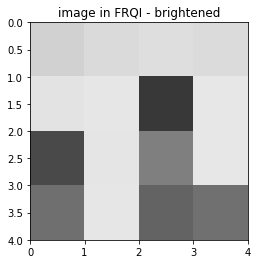

In [5]:
# To normalize image arrays:
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# To plot a 4x4 image from an array consisting of a list of pixels
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    
    
np_test_image_final_reshaped_normalized = normalize(np_test_image_final_reshaped)
print(np_test_image_final_reshaped_normalized)

plot_image4x4_brightened(np_test_image_final_reshaped_normalized, 'image in FRQI - brightened')

In [6]:
# Defining the Decrement Gate that's used in the Quantum Circuit (only for a 4x4 image)
def decrement():
    qdec = QuantumCircuit(5)
    for i in range(5):
        qdec.x(i)
    
    qdec.mct([0,1,2,3],4)
    qdec.mct([0,1,2],3)
    qdec.ccx(0,1,2)
    qdec.cx(0,1)
    qdec.x(0)
    
    for i in range(5):
        qdec.x(i)
    
    qdec = qdec.to_gate()
    qdec.name = "Decrement"
    
    return qdec

[0.27784429575556685, 0.28986640470652886, 0.29520956424028977, 0.2912021945899691, 0.3032243035409311, 0.3058958833078116, 0.07614002335609284, 0.30723167319125183, 0.09884845137457667, 0.30456009342437135, 0.16964531519690862, 0.30723167319125183, 0.148272677061865, 0.3058958833078116, 0.1322431984605823, 0.14960846694530522]


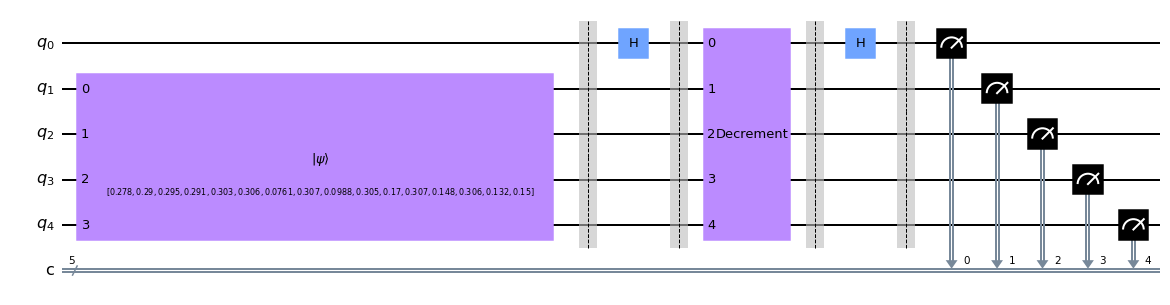

In [7]:
# Let's set up the first iteration of the qGaussian algorithm on our test image, and run it on hardware:
initial_state = []

for row in np_test_image_final_reshaped_normalized:
    for pixel in row:
        initial_state.append(pixel)

print(initial_state)

qc_1 = QuantumCircuit(5,5)
qc_1.initialize(initial_state,[1,2,3,4])
qc_1.barrier()

qc_1.h(0)
qc_1.barrier()

qc_1.append(decrement(), [0,1,2,3,4])
qc_1.barrier()

qc_1.h(0)
qc_1.barrier()

qc_1.measure([0,1,2,3,4], [0,1,2,3,4])

qc_1.draw()

In [17]:
#Firstly, let's run it on a simulator:
simulator = Aer.get_backend('aer_simulator')
qc_1_transpiled = transpile(qc_1, simulator)

# Run with 2048 shots
result_qc_1 = simulator.run(qc_1_transpiled, shots=4096).result()
counts_qc_1 = result_qc_1.get_counts()

print(counts_qc_1)

{'00111': 1, '11011': 26, '11001': 19, '10000': 185, '10101': 20, '01111': 34, '10011': 18, '01110': 177, '01000': 385, '11101': 1, '10100': 203, '00010': 394, '11111': 14, '10010': 223, '10110': 190, '11110': 192, '11100': 109, '00110': 387, '00100': 345, '01011': 58, '00000': 328, '10111': 27, '11000': 196, '11010': 185, '01101': 61, '01100': 134, '10001': 44, '01010': 140}


{'1000': 185, '0111': 177, '0100': 385, '1010': 203, '0001': 394, '1001': 223, '1011': 190, '1111': 192, '1110': 109, '0011': 387, '0010': 345, '0000': 328, '1100': 196, '1101': 185, '0110': 134, '0101': 140}
[[0.29484483 0.32315041 0.30238911 0.32026692]
 [0.31943828 0.19262853 0.18845558 0.21659241]
 [0.22143306 0.24311347 0.23195547 0.22440545]
 [0.22792115 0.22143306 0.16996905 0.22558344]]


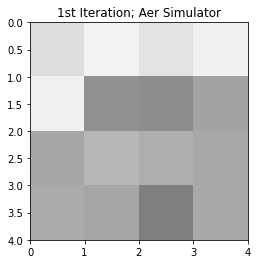

In [18]:
# Converting simulator output to pixel data to display
counts_qc_1_relevant = {qubit_order[:-1:]: shots for qubit_order, shots in counts_qc_1.items() if qubit_order[4] == '0'}

print(counts_qc_1_relevant)

get_bin = lambda x, n: format(x, 'b').zfill(n)
qc_1_pixel_array = [ counts_qc_1_relevant[get_bin(i,4)] for i in range(2**4)] 

np_qc_1_pixel_array = np.array(qc_1_pixel_array)
np_qc_1_pixel_array = np_qc_1_pixel_array / 4096
np_qc_1_pixel_array = np.sqrt(np_qc_1_pixel_array)
np_qc_1_pixel_array = normalize(np_qc_1_pixel_array)

np_qc_1_pixel_array_reshaped = np_qc_1_pixel_array.reshape((4,4))

print(np_qc_1_pixel_array_reshaped)

plot_image4x4_brightened(np_qc_1_pixel_array_reshaped, "1st Iteration; Aer Simulator")

In [19]:
# Running on Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (5) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_qc_1 = transpile(qc_1, backend, optimization_level=3)
job_1 = backend.run(transpiled_qc_1)
job_monitor(job_1, interval=2)

ibmqfactory.load_account:WARNING:2022-09-16 13:25:43,924: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito
Job Status: job is queued (27)    

KeyboardInterrupt: 

In [9]:
# The Job finally ran, so we have the following data:
job_results = {'00000': 0.0275, '00001': 0.0285, '00010':0.02025, '00011': 0.0225, '00100': 0.032, '00101': 0.03075, '00110': 0.0275, '00111': 0.02, '01000': 0.025, '01001': 0.02475, '01010': 0.01925, '01011': 0.02175, '01100': 0.02975, '01101': 0.029, '01110': 0.0225, '01111': 0.02575, '10000': 0.0345, '10001': 0.03925, '10010': 0.03675, '10011': 0.03325, '10100': 0.04525, '10101': 0.0415, '10110': 0.04225, '10111': 0.03775, '11000': 0.03775, '11001': 0.0355, '11010': 0.0335, '11011': 0.0355, '11100': 0.04025, '11101': 0.03675, '11110': 0.0355, '11111': 0.02825}

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
belem = provider.get_backend('ibmq_belem')
job_results = belem.retrieve_job('632342b128d98bbf0f844ef2').result().get_counts()
print(job_results)



ibmqfactory.load_account:WARNING:2022-09-16 14:34:58,532: Credentials are already in use. The existing account in the session will be replaced.


{'00000': 110, '00001': 114, '10000': 138, '10001': 157, '10010': 147, '10011': 133, '10100': 181, '10101': 166, '10110': 169, '10111': 151, '11000': 150, '11001': 142, '11010': 134, '11011': 142, '11100': 161, '11101': 147, '11110': 142, '11111': 113, '00010': 81, '00011': 90, '00100': 128, '00101': 123, '00110': 110, '00111': 80, '01000': 100, '01001': 99, '01010': 77, '01011': 87, '01100': 119, '01101': 116, '01110': 90, '01111': 103}


{'0000': 110, '1000': 138, '1001': 147, '1010': 181, '1011': 169, '1100': 150, '1101': 134, '1110': 161, '1111': 142, '0001': 81, '0010': 128, '0011': 110, '0100': 100, '0101': 77, '0110': 119, '0111': 90}
[[0.23238111 0.19941003 0.2506741  0.23238111]
 [0.2215667  0.19442399 0.24170073 0.21019663]
 [0.26028194 0.26863534 0.29808751 0.28803671]
 [0.27136268 0.256482   0.28113662 0.26402719]]


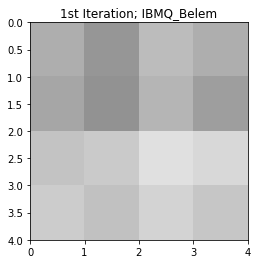

In [11]:
# Converting simulator output to pixel data to display
job_results_relevant = {qubit_order[:-1:]: shots for qubit_order, shots in job_results.items() if qubit_order[4] == '0'}

print(job_results_relevant)

get_bin = lambda x, n: format(x, 'b').zfill(n)
job_results_pixel_array = [ job_results_relevant[get_bin(i,4)] for i in range(2**4)] 

np_job_results_pixel_array = np.array(job_results_pixel_array)
np_job_results_pixel_array = np_job_results_pixel_array * 4000
np_job_results_pixel_array = np.sqrt(np_job_results_pixel_array)
np_job_results_pixel_array = normalize(np_job_results_pixel_array)

np_job_results_pixel_array_reshaped = np_job_results_pixel_array.reshape((4,4))

print(np_job_results_pixel_array_reshaped)

plot_image4x4_brightened(np_job_results_pixel_array_reshaped, "1st Iteration; IBMQ_Belem")

In [12]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')
job_results = quito.retrieve_job('6324796218355855d878064e').result().get_counts()
print(job_results)


ibmqfactory.load_account:WARNING:2022-09-16 14:36:24,435: Credentials are already in use. The existing account in the session will be replaced.


{'00000': 134, '00001': 120, '10000': 136, '10001': 128, '10010': 133, '10011': 107, '10100': 86, '10101': 110, '10110': 101, '10111': 89, '11000': 124, '11001': 86, '11010': 131, '11011': 117, '11100': 108, '11101': 126, '11110': 125, '11111': 103, '00010': 169, '00011': 128, '00100': 105, '00101': 121, '00110': 131, '00111': 139, '01000': 136, '01001': 103, '01010': 151, '01011': 142, '01100': 152, '01101': 160, '01110': 148, '01111': 151}


{'0000': 134, '1000': 136, '1001': 133, '1010': 86, '1011': 101, '1100': 124, '1101': 131, '1110': 108, '1111': 125, '0001': 169, '0010': 105, '0011': 131, '0100': 136, '0101': 151, '0110': 152, '0111': 148}
[[0.25442936 0.28573154 0.22522131 0.25156515]
 [0.25632105 0.27008676 0.27097961 0.26739032]
 [0.25632105 0.25347822 0.2038281  0.22088972]
 [0.24475167 0.25156515 0.2284161  0.24573659]]


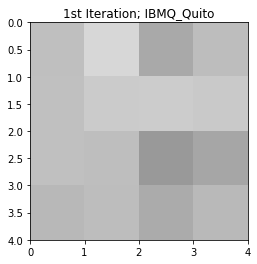

In [13]:
# Converting simulator output to pixel data to display
job_results_relevant = {qubit_order[:-1:]: shots for qubit_order, shots in job_results.items() if qubit_order[4] == '0'}

print(job_results_relevant)

get_bin = lambda x, n: format(x, 'b').zfill(n)
job_results_pixel_array = [ job_results_relevant[get_bin(i,4)] for i in range(2**4)] 

np_job_results_pixel_array = np.array(job_results_pixel_array)
np_job_results_pixel_array = np_job_results_pixel_array * 4000
np_job_results_pixel_array = np.sqrt(np_job_results_pixel_array)
np_job_results_pixel_array = normalize(np_job_results_pixel_array)

np_job_results_pixel_array_reshaped = np_job_results_pixel_array.reshape((4,4))

print(np_job_results_pixel_array_reshaped)

plot_image4x4_brightened(np_job_results_pixel_array_reshaped, "1st Iteration; IBMQ_Quito")